In [1]:
from PIL import Image

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import os
import numpy as np

In [4]:
from IPython.html import widgets
from IPython.html.widgets import interact
from IPython.display import display

/Users/j35/anaconda/lib/python3.4/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [5]:
from PyQt4 import QtGui

In [6]:
import scipy as sp
import imreg_dft as ird

In [7]:
import skimage
from skimage.feature import register_translation

### Select working folder

In [8]:
%gui qt

In [9]:
try:
    from PySide import QtCore, QtGui
except ImportError:
    from PyQt4 import QtCore, QtGui

def gui_fname(dir=None, message=None):
    """Select a directory
    """
    if dir is None: dir ='../'
    if message is None: message = 'Select Folder ...'
    dir_name = QtGui.QFileDialog.getExistingDirectory(None, message,
                                                      dir,
                                                      QtGui.QFileDialog.ShowDirsOnly)
    return dir_name

In [10]:
%gui qt
data_folder = gui_fname()
%matplotlib inline

In [11]:
# remove hidden file .DS_Store 
ds_file = os.path.join(data_folder, ".DS_Store")
try:
    os.remove(ds_file)
except:
    pass

In [12]:
list_of_files = [name for name in os.listdir(data_folder) if os.path.isfile(os.path.join(data_folder, name))]
number_of_files = len(list_of_files)
print('Folder contains %d files.' %number_of_files)

Folder contains 966 files.


### script to translate images

In [41]:
def translate_array(old_array, xoffset, yoffset, index):
    
    [ysize, xsize] = old_array.shape
    new_array = np.zeros((ysize, xsize))
    
    if True:
        print('working with image at index %d' %index)
        print('xoffset: %f' %xoffset)
        print('yoffset: %f' %yoffset)
        print()
        
    if (xoffset < 0):
        old_array_from_x = abs(xoffset)
        old_array_to_x = xsize
        new_array_from_x = 0
        new_array_to_x = xsize - abs(xoffset)

    elif (xoffset > 0):
        old_array_from_x = 0
        old_array_to_x = xsize - xoffset
        new_array_from_x = xoffset
        new_array_to_x = xsize
    
    else:
        old_array_from_x = 0
        old_array_to_x = xsize
        new_array_from_x = 0
        new_array_to_x = xsize
    
    if (yoffset < 0):
        old_array_from_y = abs(yoffset)
        old_array_to_y = ysize
        new_array_from_y = 0
        new_array_to_y = ysize - abs(yoffset)
    
    elif (yoffset > 0):
        old_array_from_y = 0
        old_array_to_y = ysize - yoffset
        new_array_from_y = yoffset
        new_array_to_y = ysize
    
    else:
        old_array_from_y = 0
        old_array_to_y = ysize
        new_array_from_y = 0
        new_array_to_y = ysize
   
    if True:
        print('working with x')
        print("old_array_from_x: %d" %old_array_from_x)
        print("old_array_to_x: %d" %old_array_to_x)
        print()
        print("new_array_from_x: %d" %new_array_from_x)
        print("new_array_to_x: %d" %new_array_to_x)

        print("\n")
        print("working with Y")
        print("old_array_from_y: %d" %old_array_from_y)
        print("old_array_to_y: %d" %old_array_to_y)
        print()
        print("new_array_from_y: %d" %new_array_from_y)
        print("new_array_to_y: %d" %new_array_to_y)
    
    
    new_array[new_array_from_y: new_array_to_y, new_array_from_x: new_array_to_x] = \
    old_array[old_array_from_y: old_array_to_y, old_array_from_x: old_array_to_x]
    
    return new_array

### Select region to crop (where the registration calculation will be performed)

In [14]:
# selection tool (x, y, width, height) with slider to go over all the images

In [21]:
im0 = sp.misc.imread(os.path.join(data_folder, list_of_files[0]))
height, width = im0.shape

In [29]:
def plot_image_with_crop_region(index_image, x_left, x_right, y_top, y_bottom):

    fig = plt.figure(figsize=(10, 10))
    ax_img = plt.subplot(111)

    image_name = os.path.join(data_folder, list_of_files[index_image])
    image = sp.misc.imread(image_name)

    ax_img.imshow(image, cmap='viridis')
    ax_img.axvline(x_left, color='#00aa00', linewidth=4)
    ax_img.axvline(x_right, color='#00aa00', linewidth=4)
    ax_img.axhline(y_bottom, color='#aa0000', linewidth=4)
    ax_img.axhline(y_top, color='#aa0000', linewidth=4)   
    
    return [x_left, x_right, y_top, y_bottom]

[15, 139, 0, 253]

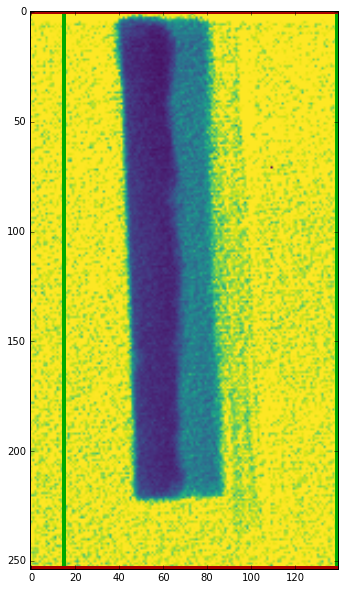

In [30]:
crop = interact(plot_image_with_crop_region, 
        index_image = widgets.IntSlider(min=0, max=number_of_files, value=0, step=1),
        x_left = widgets.IntSlider(min=0, max=width-1, step=1, value=0),
        x_right = widgets.IntSlider(min=0, max=width-1, step=1, value=width-1),
        y_top = widgets.IntSlider(min=0, max=height-1, step=1, value=0), 
        y_bottom = widgets.IntSlider(min=0, max=height-1, step=1, value=height-1))

In [39]:
[x_left, x_right, y_top, y_bottom] = crop.widget.result
selection = [x_left, x_right, y_top, y_bottom]
print('** Selection **')
print('x_left: %d' %x_left)
print('x_right: %d' %x_right)
print('y_top: %d' %y_top)
print('y_bottom: %d' %y_bottom)

** Selection **
x_left: 15
x_right: 139
y_top: 0
y_bottom: 253


In [16]:
# start with first image, appply crop to get new image and perform same operation on second image .. and register

In [26]:
new_im = []
new_im.append(im0)

In [40]:
def cropped_image(image_source, selection):
    [x_left, x_right, y_top, y_bottom] = selection
    return image_source[y_top:y_bottom, x_left:x_right]

In [ ]:
w = widgets.IntProgress()
w.max = (number_of_files-1)
display(w)

cropped_im0 = cropped_image(im0, selection)

for index in range(1, number_of_files):
    
    im_index = sp.misc.imread(os.path.join(data_folder, list_of_files[index]))
    # keep only cropped region
    cropped_im_index = cropped_image(im_index, selection)
    shift, error, diffphase = register_translation(cropped_im0, cropped_im_index)
    
    #print(result['angle'])
    [yoffset, xoffset] = shift
    
    new_array = translate_array(im_index, int(xoffset), int(yoffset), index)
    new_im.append(new_array)
    
    w.value = index


### Check results 

In [ ]:
# repeat for following images and 
## * use previous image as template
## * use first image as template
# and compare results

In [18]:
# display results (images) and allow to display profiles of various successives images to compare the plots

### Load the template (first image) and another image from the stack

In [140]:
image_template_name = os.path.join(data_folder, list_of_files[0])
print("image_template is: ", image_template_name)

image_template is:  /Users/j35/git/notebooks/myIPythonNotebookTutorial/registration/data/image_0.tiff


In [141]:
im0 = sp.misc.imread(image_template_name)
im0.shape

(254, 140)

In [142]:
image_1_name = os.path.join(data_folder, list_of_files[5])
print('image_1_name is: ', image_1_name)

image_1_name is:  /Users/j35/git/notebooks/myIPythonNotebookTutorial/registration/data/image_300.tiff


In [143]:
im1 = sp.misc.imread(image_1_name)
im1.shape

(254, 140)

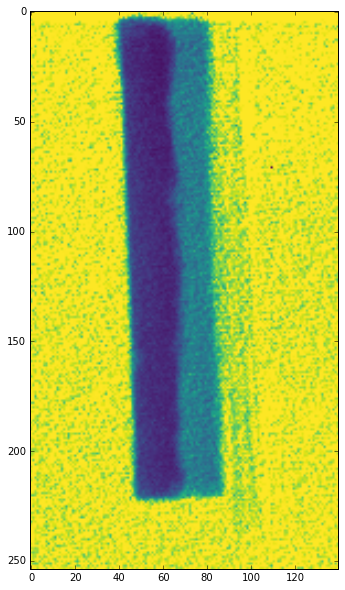

In [144]:
#check display
plt.figure(figsize=(10, 10))
plt.imshow(im0, cmap='viridis')

### Loop through all images to find offsets (using first as reference)

In [145]:
new_im = []
new_im.append(im0)
print(im0.shape)

(254, 140)


In [151]:
w = widgets.IntProgress()
w.max = (number_of_files-1)
display(w)

for index in range(1, number_of_files):
    
    im_index = sp.misc.imread(os.path.join(data_folder, list_of_files[index]))
    shift, error, diffphase = register_translation(im0, im_index)
    
    #print(result['angle'])
    [yoffset, xoffset] = shift
    
    new_array = translate_array(im_index, int(xoffset), int(yoffset), index)
    new_im.append(new_array)
    
    w.value = index


working with image at index 1
xoffset: 4.000000
yoffset: 3.000000

working with x
old_array_from_x: 0
old_array_to_x: 136

new_array_from_x: 4
new_array_to_x: 140


working with Y
old_array_from_y: 0
old_array_to_y: 251

new_array_from_y: 3
new_array_to_y: 254
working with image at index 2
xoffset: 7.000000
yoffset: 2.000000

working with x
old_array_from_x: 0
old_array_to_x: 133

new_array_from_x: 7
new_array_to_x: 140


working with Y
old_array_from_y: 0
old_array_to_y: 252

new_array_from_y: 2
new_array_to_y: 254
working with image at index 3
xoffset: 7.000000
yoffset: 2.000000

working with x
old_array_from_x: 0
old_array_to_x: 133

new_array_from_x: 7
new_array_to_x: 140


working with Y
old_array_from_y: 0
old_array_to_y: 252

new_array_from_y: 2
new_array_to_y: 254
working with image at index 4
xoffset: 7.000000
yoffset: 2.000000

working with x
old_array_from_x: 0
old_array_to_x: 133

new_array_from_x: 7
new_array_to_x: 140


working with Y
old_array_from_y: 0
old_array_to_y: 2

# Check results

<function __main__.plot_results>

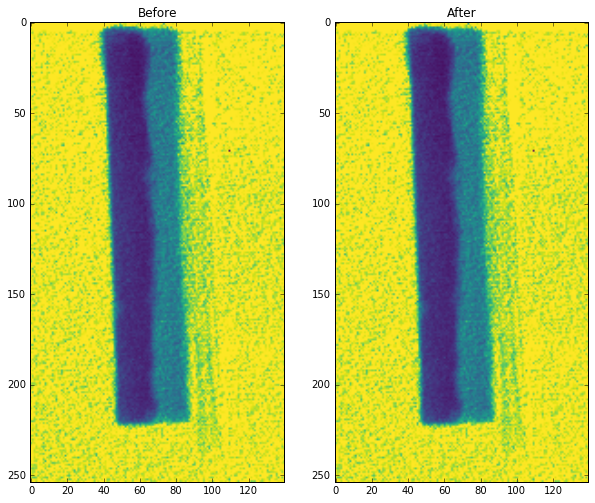

In [153]:
def plot_results(index):
    
    fig = plt.figure(figsize=(10,10))
    ax_img_b = plt.subplot(1,2,1)

    data_before = sp.misc.imread(os.path.join(data_folder, list_of_files[index]))
    ax_img_b.imshow(data_before, cmap='viridis')
    ax_img_b.set_title("Before")
    
    ax_img_a = plt.subplot(1,2,2)
    data_after = new_im[index]
    ax_img_a.imshow(data_after, cmap='viridis')
    ax_img_a.set_title('After')
    
interact(plot_results, 
        index = widgets.IntSlider(min=0, max=number_of_files-1, step=1, value=0))
    
    

# Works !!!!!